In [ ]:
from torch.utils.cpp_extension import load

gp_interp_cuda = load('gp_interp_cuda', ['gp_interp_cuda.cpp', 'gp_interp_cuda_kernel.cu'], verbose=True)

import sys; sys.path.extend(['.', '../cuda'])

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TVF

from gp_interp import GPInterp

device = 'cuda'
# img_pil = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
# img_pil = Image.open('./water.jpg')
# img = TVF.to_tensor(img_pil).to(device)
size = 30
img = torch.linspace(1, 0, size).view(-1, 1).repeat(1, size).unsqueeze(2).to(device).permute(2, 0, 1)
gp = GPInterp(img.shape[1], img.shape[2], 0.6, 1.0, 5)
gp.to(device)

print('Num coords:', len(gp.means))

print('Doing a forward pass...')
out = gp(img)

print('Doing a backward pass...')
loss = (out - img).abs().mean()
loss.backward()
print('Loss:', loss.item())
print('Success!')

TVF.to_pil_image(out.cpu())

Using /tmp/torch_extensions as PyTorch extensions root...
The input conditions for extension module gp_interp_cuda have changed. Bumping to version 1 and re-building as gp_interp_cuda_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /tmp/torch_extensions/gp_interp_cuda/build.ninja...
Building extension module gp_interp_cuda_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


In [ ]:
gp.means.grad

In [3]:
gp.stds.grad

tensor([[-0.6889, -0.6889],
        [-0.0761, -0.9335],
        [-0.6889, -0.6889],
        [-0.4667, -0.0381],
        [-0.0526, -0.0526],
        [-0.4667, -0.0381],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0')

In [104]:
tqdm._instances.clear()

In [105]:
from tqdm import tqdm

gp = GPInterp(img.shape[1], img.shape[2], img.shape[0], 0.2, 2.5, 5)
gp.to(device)
means_old = gp.means.data.cpu().tolist()
optim = torch.optim.SGD(gp.parameters(), lr=0.000001)
# optim = torch.optim.Adam(gp.parameters(), lr=0.0001, betas=(0.5, 0.98))

for i in tqdm(range(500)):
    out = gp(img)
    loss = (out - img).pow(2).mean()
    optim.zero_grad()
    loss.backward()
    #torch.nn.utils.clip_grad_value_(gp.parameters(), 1.0)
    optim.step()
    if i % 100 == 0:
        print(f'{loss.item():.05f}')
        
print('diff passed:', (torch.tensor(means_old).to(device) - gp.means).abs().mean())

  6%|▌         | 30/500 [00:00<00:03, 145.57it/s]

0.00111


 24%|██▍       | 120/500 [00:00<00:02, 146.92it/s]

0.00111


 45%|████▌     | 225/500 [00:01<00:01, 147.86it/s]

0.00111


 66%|██████▌   | 330/500 [00:02<00:01, 147.73it/s]

0.00111


 84%|████████▍ | 420/500 [00:02<00:00, 147.64it/s]

0.00111


100%|██████████| 500/500 [00:03<00:00, 147.70it/s]

diff passed: tensor(1.0948e-05, device='cuda:0', grad_fn=<MeanBackward0>)


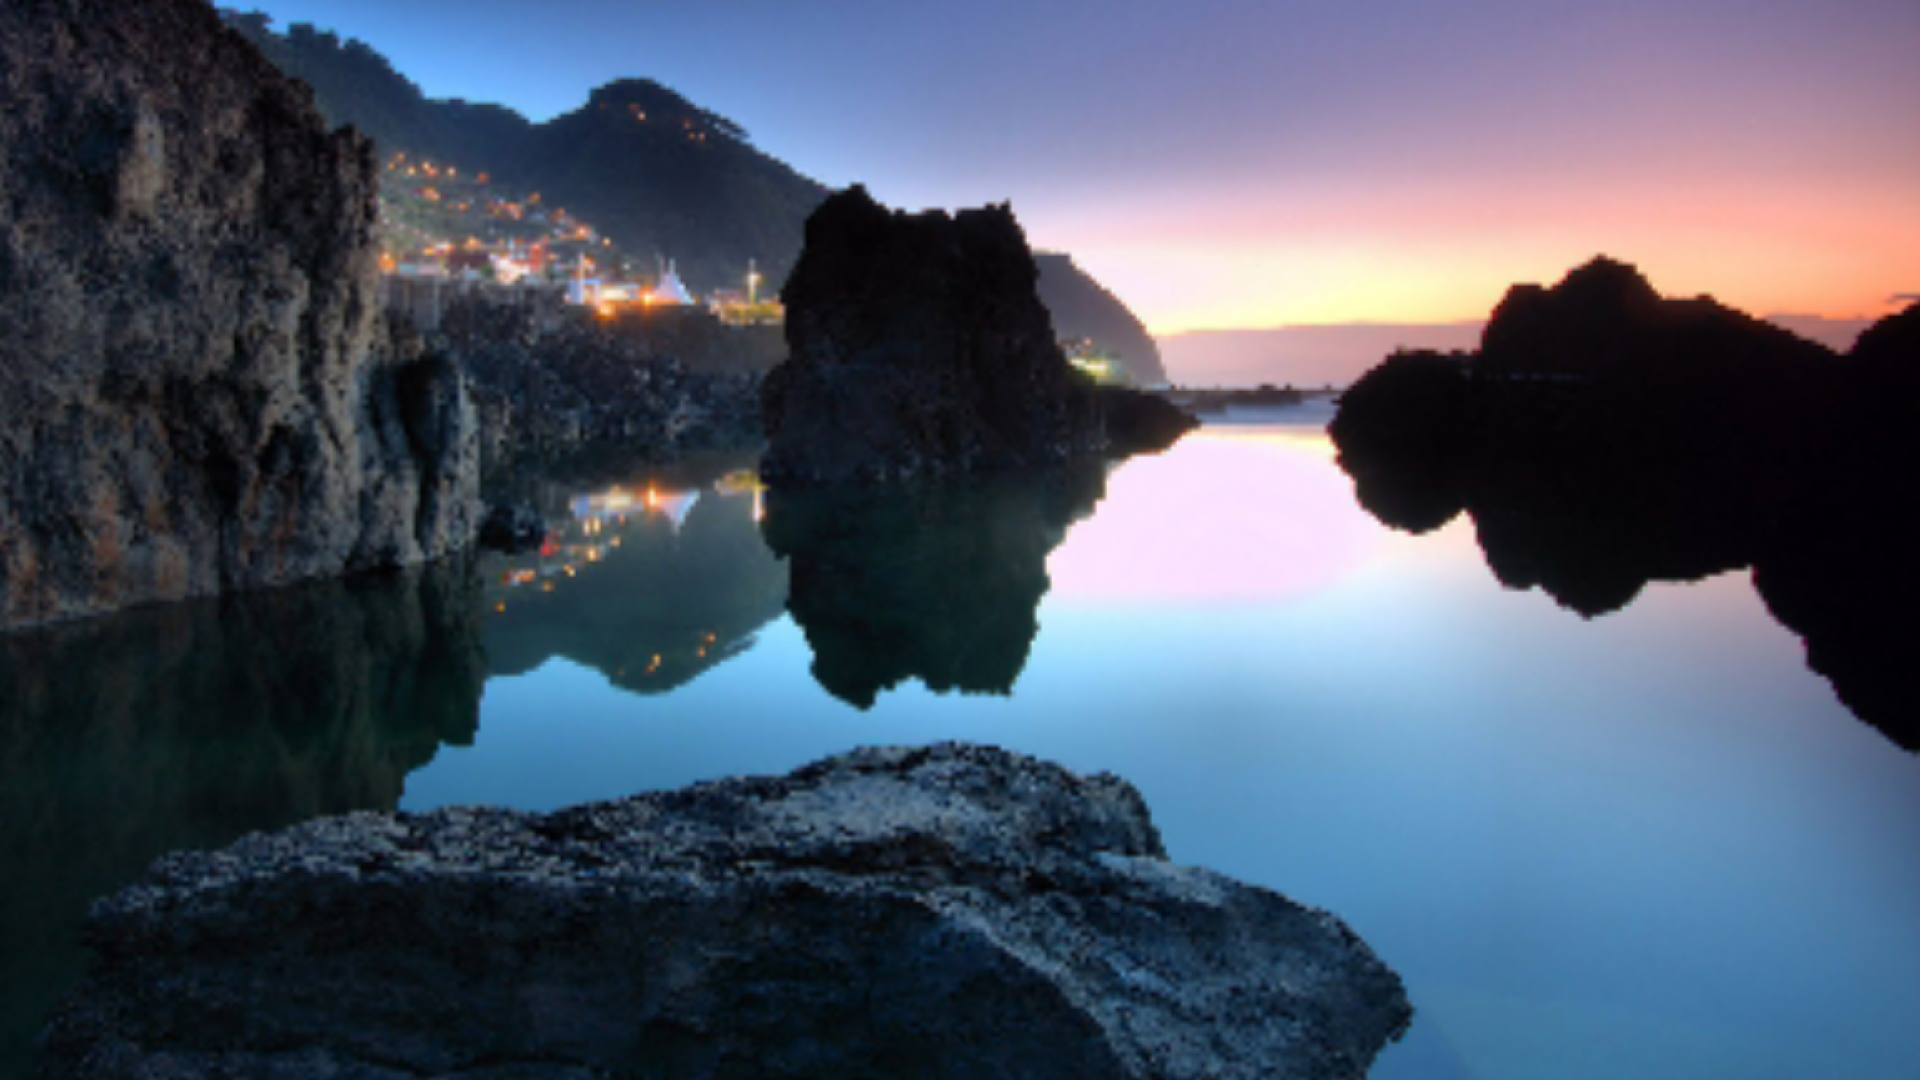

In [102]:
TVF.to_pil_image(out.cpu())